1. # 🛠 Install Libraries

## For PC

In [1]:
#!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113
#!pip install --user numpy 
#!pip install --user pandas 
#!pip install  segmentation-models-pytorch
# !python -m pip install opencv-python
# !pip install tensorflow
# !pip install -q scikit-learn==1.0
#!pip install plotly
# !pip install --user albumentations
# import sys  
# !{sys.executable} -m pip install --user matplotlib
#!pip install ipywidgets --user
#!pip install -U albumentations[imgaug]

## For Kaggle !!

In [2]:
#!pip install  segmentation-models-pytorch

# 📚 Import Libraries  


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import segmentation_models_pytorch as smp
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy

from IPython import display as ipd
from PIL import Image

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sklearn
import sklearn
from sklearn.model_selection import train_test_split

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import timm

# Albumentations for augmentations
import albumentations as A

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# gc
import gc

import shutil, os

## Versions

In [6]:
print(f'Torch version{torch.__version__}')
print('The scikit-learn version is {}.'.format(sklearn.__version__))
#print(f'Numpy version: {np.ve}')
import platform
print(f"Python version: {platform.python_version()}")
#torchvision

Torch version1.11.0+cu113
The scikit-learn version is 1.0.2.
Python version: 3.9.12


# ⚙️ Configuration 

In [7]:
class CFG:
    JUST_PREDICT  = False
    Kaggle        = False 
    DEBUG         = False
    wandb_on      = False
    seed          = 101
    MULTIMODEL    = False
    weights       = 'imagenet'
    backbone      = 'efficientnet-b2'# 'timm-mobilenetv3_small_minimal_100' #'efficientnet-b1'
    models        = []
    optimizers    = []
################################################### 
    num_of_models = 1
    model_number  = 1
    train_bs      = 4
    valid_bs      = 4
    number_imgs   = 100 if DEBUG else 8203     #8203
    num_test      = 10 if DEBUG else 1000      # 1000
    print_every   = 1  if DEBUG else 100      #500
    img_size      = [256, 256] #[540, 960]
    start_width   = 512
    start_height  = 512
    final_width   = 512
    final_height  = 512
    epochs        = 2  if DEBUG else 80        #35
    ###############################################
    crop_koef     = 1
    lr            = 0.002
    num_workers   = 4 if Kaggle else 0
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 0 #1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 4
    classes       = [0,6,7,10]
    activation    = None #'softmax'
    device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    images_path   = "../input/russian-railways-2/images/images/" if Kaggle else "./train/images/" #"../Цифровой прорыв 2022_Лето\train\images"
    masks_path    = "../input/russian-railways-2/mask/mask/" if Kaggle else  "./train/mask/"
    test_path     = "../input/russian-railways-2/test/test/" if Kaggle else "./test/"
    save_path     = '../working/result/' if Kaggle else "./result/"
    best_model_w  = '../input/russian-railways-2/best_epoch_ofu-efficientnet-b1_v2.bin' if Kaggle else './last_epoch_ofu-efficientnet-b1_v2.bin'
#'../input/russian-railways-2/best_epoch.bin'

device(type='cuda')

# ❗ Reproducibility

In [12]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


# 📈 Visualization

In [15]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [19]:
gc.collect() # gc.collect() возвращает количество объектов, которые были собраны и удалены.

0

# 📦 Model


In [20]:

import segmentation_models_pytorch as smp



    
##################################################################################################################################################################    
    
##################################################################################################################################################################    
def build_model(indx):
    if indx == 1: #'model_Unet':
        model = smp.Unet(
            encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
            in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
            activation=CFG.activation)
    
    model.to(CFG.device)
    CFG.models = [model]
    return  model


def load_models(pash):
    for model in CFG.models:
        model = build_model(model)


def load_model(path,indx):
    model = build_model(indx)
    model.load_state_dict(torch.load(path))
    model.eval()
    model.to(CFG.device)
    CFG.models = [model]
    return model

# 🔧 Loss Function

In [21]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel') # Intersection over Union: like dice (index) The Intersection-Over-Union (IoU), also known as the Jaccard Index
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False) # parametrised Jaccard loss || log_loss – If True, --> -log(tversky) else 1 - tversky

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

# IOU
# from keras import backend as K
# def iou_coef(y_true, y_pred, smooth=1):
#     intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
#     union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
#     iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
#     return iou

def criterion(y_pred, y_true):
    return 0.4*BCELoss(y_pred, y_true) + 0.6*TverskyLoss(y_pred, y_true)

# 🚄 Training Function

In [22]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch ):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:  
    #step = 1
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)

        batch_size = images.size(0)

        with amp.autocast(enabled=True): # choose best presition (float32 or float16 for each operation to speed up and best performance)


    ###################### FORWARD ######################################################################

            y_pred = model(images)
                                    #print(y_pred.size()) # gives torch.Size([4, 4, 256, 256]) (BS, CALSSES, W, H)
                                    #print(masks.size()) # gives torch.Size([4, 3, 256, 256])
            loss   = criterion(y_pred, masks)
            loss   = loss / CFG.n_accumulate #???????

    ####################### BACKWARD #####################################################################  

                # Exits autocast before backward().
                # Backward passes under autocast are not recommended.
                # Backward ops run in the same dtype autocast chose for corresponding forward ops.

    ########################################################################################################
        scaler.scale(loss).backward()

        if (step + 1) % CFG.n_accumulate == 0: # остаток от деления это сделано верно
            scaler.step(optimizer) #step - обновление весов модели
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad() #zero_grad - занулить веса модели (по умолчанию градиенты в PyTorch аккумулируются) 

            if scheduler is not None: # ???????
                scheduler.step()      # ??????? не здесь а после валидации

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
        
 #########################################################################################################################       
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss

# 👀 Validation Function

In [23]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval() # remove dropout, batchnorm # we use it when checking results
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
################## FORWARD ##################################################

        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred) # ?????
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr'] # returns actual LR
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

In [24]:
#smp.utils.train.TrainEpoch?

# 🏃 Run Training (Training loop)

In [25]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
    if CFG.wandb_on:
        wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_jaccard   = -np.inf
    best_epoch     = -1
    #history = defaultdict(list)
    
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect() # garbage collector - to delete references and objects that not exist any more
        
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
        val_dice, val_jaccard = val_scores
    
#         history['Train Loss'].append(train_loss)
#         history['Valid Loss'].append(val_loss)
#         history['Valid Dice'].append(val_dice)
#         history['Valid Jaccard'].append(val_jaccard)
        
        #Log the metrics
        if CFG.wandb_on:
            wandb.log({"Train Loss": train_loss, 
                       "Valid Loss": val_loss,
                       "Valid Dice": val_dice,
                       "Valid Jaccard": val_jaccard,
                        "LR": optimizer.param_groups[0]['lr'] # returns actual LRscheduler.get_last_lr()[0]
                      })
        
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        
        # deep copy the model
        if val_dice >= best_dice: 
            print(f"{c_}Valid Score  (IOU) ({best_jaccard:0.4f} ---> {val_jaccard:0.4f})")
            print(f"{c_}Valid Score Improved(DICE) ({best_dice:0.4f} ---> {val_dice:0.4f})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_epoch   = epoch
            if CFG.wandb_on:
                run.summary["Best Dice"]    = best_dice
                run.summary["Best Jaccard"] = best_jaccard
                run.summary["Best Epoch"]   = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_epoch_of{model.name}_v2.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            if CFG.wandb_on:
                wandb.save(PATH)
                print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"last_epoch_of{model.name}_v2.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model #, history

## Loading models !

In [26]:

# # #model = build_model()
if CFG.JUST_PREDICT:
#################################################################################################################################
    try:
        model = load_model(CFG.best_model_w,1) 
        preprocessing_fn = smp.encoders.get_preprocessing_fn(CFG.backbone, CFG.weights)
        print(f'WE WILL TRAIN TRAINED MODEL: {model.name} !!!')
    except Exception:
        model = build_model(CFG.model_number)
        preprocessing_fn = smp.encoders.get_preprocessing_fn(CFG.backbone, CFG.weights)
        print(f'WE WILL TRAIN NEW MODEL: {model.name} !!!')
##########################################################################################


else:
    model = build_model(CFG.model_number)  
    preprocessing_fn = smp.encoders.get_preprocessing_fn(CFG.backbone, CFG.weights)
    print(f'WE TRAIN NEW MODEL {model.name}')


#PATH = f"best_epoch.bin"
#torch.save(model.state_dict(), PATH)

WE TRAIN NEW MODEL u-efficientnet-b2


In [27]:


def load_img(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def load_msk(path):
    msk = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # or msk=cv2.imread(path, 0)
    masks = [(msk == v) for v in CFG.classes]
    msk = np.stack(masks, axis=-1).astype('float')
    return msk
    
def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    plt.imshow(img, cmap='bone')
    
    
    if mask is not None:
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["main rails", "rails", "Trains", 'Background']
        plt.legend(handles,labels)
    plt.axis('off')
    
    
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)

def get_preprocessing_test(preprocessing_fn):
    _transform = [
        A.Lambda(image=preprocessing_fn),
        A.Lambda(image=to_tensor),
    ]
    return A.Compose(_transform)

In [28]:
class BuildDataset(torch.utils.data.Dataset):
#      """ Read images, apply augmentation and preprocessing transformations.
#     Args:
#         images_dir (str): path to images folder
#         masks_dir (str): path to segmentation masks folder
#         class_values (list): values of classes to extract from segmentation mask
#         augmentation (albumentations.Compose): data transfromation pipeline 
#             (e.g. flip, scale, etc.)
#         preprocessing (albumentations.Compose): data preprocessing 
#             (e.g. noralization, shape manipulation, etc.)
#     fdgdfgdfgdfg""" 

    def __init__(self, images_paths, masks_paths = None, label=True, transforms=None,  preprocessing= None):
        self.label      = label
        self.img_paths  = images_paths
        self.msk_paths  = masks_paths
        self.transforms = transforms
        self.preprocessing = preprocessing
        self.preprocessing_img = get_preprocessing_test(preprocessing_fn)
        #self.transforms_img = data_transforms['valid']
    def __len__(self):
        return len(self.img_paths)
    
    
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        #img = []
        img = load_img(img_path)
        
        if self.label: # WHEN WE TRAIN 
            msk_path = self.msk_paths[index]
            msk = load_msk(msk_path)
            
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img, msk  = data['image'], data['mask']
            if self.preprocessing:
                data = self.preprocessing(image=img, mask=msk)
                img, msk  = data['image'], data['mask']
            return img, msk
        else: # WHEN WE PREDICT
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            if self.preprocessing:
                data =  self.preprocessing_img(image=img)
                img = data['image']
            return img    

In [29]:
#A.Sharpen?

In [30]:
data_transforms = {
    "train": A.Compose([
       A.HorizontalFlip(p=0.5),
        A.Resize(height=CFG.start_height, width=CFG.start_width, interpolation=cv2.INTER_NEAREST),
        
        #A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.3, border_mode=0),
        #A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.OneOf(
            [
                 A.RandomCrop(height=CFG.final_height, width=CFG.final_width, always_apply=True),
                 A.CenterCrop(height =CFG.final_height, width =CFG.final_width,p =1.0),
            ],
            p=1.0,
        ),
         A.IAAAdditiveGaussianNoise(p=0.2),
         A.IAAPerspective(p=0.5),

#         A.OneOf(
#             [
#                 A.CLAHE(p=1),
#                 A.RandomBrightness(p=1),
#                 A.RandomGamma(p=1),
#             ],
#             p=0.9,
#         ),

#         A.OneOf(
#             [
#                 A.Sharpen(p=0.5),
#                 A.Blur(blur_limit=3, p=1),
#                 A.MotionBlur(blur_limit=3, p=1), # размытие
#             ],
#             p=0.1,
#         ),
#COLOR AUGMENTATIONS
#         A.OneOf(
#             [
#                 A.RandomContrast(p=1),
#                 A.HueSaturationValue(p=1), # scale  like rgb
#             ],
#             p=0.2,
#         ),
         ], p=1.0),
    
    "valid": A.Compose([
        #A.PadIfNeeded(384, 480),
        #A.LongestMaxSize(max_size = 320)
        #A.RandomCrop(height=1024, width=1024, always_apply=True),
        A.Resize(height=CFG.start_height, width=CFG.start_width, interpolation=cv2.INTER_NEAREST),
        
        ], p=1.0)
#,
#     "mask": A.Compose([
#         A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
#         A.Normalize(mean=(0.485, 0.456, 0.406),
#                     std=(0.229, 0.224, 0.225),
#                     max_pixel_value=255.0,
#                     always_apply=False,
#                     p=1.0,),
#         ], p=1.0)
}

# 🍰 DataLoader

In [31]:
def prepare_loaders():
    
    img_names= [ os.path.join(CFG.images_path,img_name) for img_name in os.listdir(CFG.images_path)]
    masks_names = [ os.path.join(CFG.masks_path,mask_name) for mask_name in os.listdir(CFG.masks_path)]
    img_names = img_names[0:CFG.number_imgs]
    masks_names=masks_names[0:CFG.number_imgs]
    image_train, image_valid, mask_train, mask_valid = train_test_split(img_names, masks_names, test_size=0.2, random_state=CFG.seed)

    
    
    train_dataset = BuildDataset(image_train, mask_train, transforms=data_transforms['train'],preprocessing=get_preprocessing(preprocessing_fn))
    valid_dataset = BuildDataset(image_valid, mask_valid, transforms=data_transforms['valid'],preprocessing=get_preprocessing(preprocessing_fn))

    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, 
                              num_workers=CFG.num_workers, shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, 
                              num_workers=CFG.num_workers, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 512, 512) (4, 512, 512)
(512, 512, 3) (512, 512, 4)


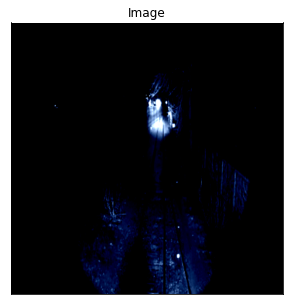

In [32]:
img_names= [ os.path.join(CFG.images_path,img_name) for img_name in os.listdir(CFG.images_path)]
masks_names = [ os.path.join(CFG.masks_path,mask_name) for mask_name in os.listdir(CFG.masks_path)]
img_names = img_names[0:CFG.number_imgs]
masks_names=masks_names[0:CFG.number_imgs]
image_train, image_valid, mask_train, mask_valid = train_test_split(img_names, masks_names, test_size=0.2, random_state=CFG.seed)
train_dataset = BuildDataset(image_train, mask_train, transforms=data_transforms['train'],preprocessing=get_preprocessing(preprocessing_fn))
img, msk = train_dataset[30]
print(img.shape, msk.shape)
img = img.transpose(1,2,0)

msk = msk.transpose(1,2,0)
print(img.shape, msk.shape)
#print(img, msk)
visualize(
    image=img, 
    #cars_mask=msk.squeeze(-1),
)

In [33]:
train_loader, valid_loader = prepare_loaders()

In [34]:
imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()

(torch.Size([4, 3, 512, 512]), torch.Size([4, 4, 512, 512]))

## Optimiser and Scheduler

In [35]:
def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, ##  <---
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None
        
    return scheduler

In [36]:
def build_optimizers(number):
    if number == 1:
        optimizer_1 = optim.Adam(CFG.models[0].parameters(), lr=CFG.lr, weight_decay=CFG.wd)
        CFG.optimizers = [optimizer_1]
    else:
        optimizer_1 = optim.Adam(CFG.models[0].parameters(), lr=CFG.lr, weight_decay=CFG.wd)
        optimizer_2 = optim.Adam(CFG.models[1].decoder.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
        optimizer_3 = optim.Adam(CFG.models[2].decoder.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
        optimizer_4 = optim.Adam(CFG.models[3].decoder.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
        optimizer_5 = optim.Adam(CFG.models[4].parameters(), lr=CFG.lr, weight_decay=CFG.wd)
        optimizer_6 = optim.Adam(CFG.models[5].parameters(), lr=CFG.lr, weight_decay=CFG.wd)
        optimizer_7 = optim.Adam(CFG.models[6].parameters(), lr=CFG.lr, weight_decay=CFG.wd)
        optimizer_8 = optim.Adam(CFG.models[7].parameters(), lr=CFG.lr, weight_decay=CFG.wd)
        CFG.optimizers = [optimizer_1,optimizer_2,optimizer_3,optimizer_4,optimizer_5,optimizer_6,optimizer_7,optimizer_8]
    return CFG.optimizers

In [37]:
#CFG.models = [model_Unet,model_UnetPP,model_inceptionresnetv2, model_Deep_lab, model_dl2, model_pan, model_pan2, model_mobile]
optimizers = build_optimizers(1)
scheduler =  fetch_scheduler(CFG.optimizers[0])# None # Decrease LR when needed, useless with  Adam (has adaptive LR) optimizer_1

# 🚅 Training

In [38]:
torch.cuda.empty_cache()

In [39]:
# loss = smp.utils.losses.DiceLoss()
# metrics = [ smp.utils.metrics.IoU(threshold=0.5),]
# for ind,  model in enumerate(CFG.models, start=0):
#     train_epoch = smp.utils.train.TrainEpoch(
#     model, 
#     loss=loss, 
#     metrics=metrics, 
#     optimizer=CFG.optimizers[ind],
#     device=CFG.device,
#     verbose=True,
# )

#     valid_epoch = smp.utils.train.ValidEpoch(
#     model, 
#     loss=loss, 
#     metrics=metrics, 
#     device=CFG.device,
#     verbose=True,)
#     max_score = 0

#     for i in range(0, CFG.epochs):

#         print('\nEpoch: {}'.format(i))
#         train_logs = train_epoch.run(train_loader)
#         valid_logs = valid_epoch.run(valid_loader)

#         # do something (save model, change lr, etc.)
#         if max_score < valid_logs['iou_score']:
#             print(f"{c_} Score Improved (IOU) ({max_score:0.4f} ---> {valid_logs['iou_score']:0.4f})")
#             max_score = valid_logs['iou_score']
#             PATH = f"best_epoch_of{model.name}.bin"
#             torch.save(model.state_dict(), PATH)
#             print(f"{c_} Score Improved (IOU) ({max_score:0.4f} ---> {valid_logs['iou_score']:0.4f})")
#             print('Model saved!')

#         if i == 25:
#             optimizer.param_groups[0]['lr'] = 1e-5
#             print('Decrease decoder learning rate to 1e-5!')

In [ ]:
if not CFG.JUST_PREDICT:
    for fold in range(1):
        print(f'#'*15)
        print(f'### Fold: {fold}')
        print(f'#'*15)
    #     run = wandb.init(project='Rails 8 NNs, 
    #                      config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
    #                      anonymous=anonymous,
    #                      name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",
    #                      group=CFG.comment,
    #                     )
        for ind,  model in enumerate(CFG.models, start=0):
            train_loader, valid_loader = prepare_loaders()
            optimizer = CFG.optimizers[ind]
            model = run_training(model, optimizer, scheduler, #history
                                          device=CFG.device,
                                          num_epochs=CFG.epochs)
        if CFG.wandb_on:
            run.finish()
            display(ipd.IFrame(run.url, width=1000, height=720))

###############
### Fold: 0
###############
cuda: NVIDIA GeForce GTX 1060 6GB

Epoch 1/80

Valid : 100%|█████████████████████| 411/411 [07:09<00:00,  1.04s/it, gpu_memory=1.00 GB, lr=0.00200, valid_loss=0.1282]


Valid Dice: 0.8011 | Valid Jaccard: 0.7493
Valid Score  (IOU) (-inf ---> 0.7493)
Valid Score Improved(DICE) (-inf ---> 0.8011)


Epoch 2/80

Valid : 100%|█████████████████████| 411/411 [07:22<00:00,  1.08s/it, gpu_memory=1.05 GB, lr=0.00200, valid_loss=0.1213]


Valid Dice: 0.8246 | Valid Jaccard: 0.7775
Valid Score  (IOU) (0.7493 ---> 0.7775)
Valid Score Improved(DICE) (0.8011 ---> 0.8246)


Epoch 3/80

Train :  75%|████████████████▌     | 1236/1641 [35:56<10:52,  1.61s/it, gpu_mem=2.43 GB, lr=0.00200, train_loss=0.0160]

# Make a new directory for results !

In [ ]:
try:
    if CFG.Kaggle:
        os.mkdir('../working/result')
        print('KAGGLE DIR CREATED')
    else:
        try: 
            shutil.rmtree(f'./result')
        except Exception:
            print("DIR NOT deleted")
            pass
        os.mkdir(f'./result')
        print('PC DIR CREATED')
except Exception:
    print("DIR NOT CREATED")
    pass
    

# 🔭 Prediction

In [ ]:

img_names_test= [ os.path.join(CFG.test_path,img_name) for img_name in os.listdir(CFG.test_path)]
img_names_test = img_names_test[0:CFG.num_test]
print(len(img_names_test))
# dicta = []
# for image_file in img_names_test:
#     img = Image.open(image_file).convert("RGB")
#     orig_size=img.size
#     dicta.append(orig_size)
sizes = [(3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), 
         (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160),
         (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512),
         (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512),
         (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512),
         (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), 
         (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), 
         (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), 
         (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), 
         (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), 
         (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), 
         (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160),
         (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), 
         (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), 
         (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), 
         (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), 
         (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), 
         (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), 
         (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), 
         (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), 
         (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), 
         (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), 
         (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), 
         (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), 
         (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), 
         (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), 
         (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), 
         (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), 
         (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), 
         (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512),
         (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), 
         (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), 
         (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), 
         (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), 
         (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512),
         (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512),
         (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160),
         (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), 
         (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), 
         (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), 
         (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), 
         (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), 
         (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), 
         (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), 
         (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), 
         (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160),
         (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160),
         (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160),
         (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512),
         (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160),
         (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512),
         (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), 
         (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), 
         (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), 
         (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), 
         (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), 
         (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), 
         (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), 
         (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), 
         (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), 
         (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), 
         (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), 
         (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), 
         (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512),
         (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), 
         (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), 
         (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), 
         (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512),
         (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), 
         (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), 
         (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), 
         (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512),
         (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), 
         (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), 
         (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), 
         (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), 
         (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), 
         (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), 
         (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), 
         (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), 
         (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), 
         (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), 
         (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), 
         (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), 
         (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), 
         (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), 
         (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), 
         (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), 
         (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), 
         (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), 
         (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), 
         (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), 
         (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), 
         (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), 
         (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), 
         (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), 
         (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), 
         (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), 
         (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), 
         (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), 
         (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512),
         (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), 
         (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), 
         (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), 
         (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), 
         (2688, 1512), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), 
         (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (2688, 1512), (3840, 2160), 
         (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512),
         (3840, 2160), (2688, 1512), (2688, 1512), (3840, 2160), (2688, 1512), (2688, 1512), (2688, 1512), (3840, 2160), (3840, 2160), 
         (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), 
         (3840, 2160),(3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160), (3840, 2160), (3840, 2160), (3840, 2160), (2688, 1512), (3840, 2160)]
#masks_names = [ os.path.join(masks_path,img_name) for img_name in os.listdir(images_path)]


save_path = CFG.save_path
preds = []

###########################################################################################################################
###########################################################################################################################
##################################################### ONE MODEL SISTEM ####################################################
###########################################################################################################################
###########################################################################################################################

if not CFG.MULTIMODEL: 
    print("ONE_MODEL_MODE")
    for indx, model in enumerate(CFG.models, start=1):
        test_dataset = BuildDataset(img_names_test,None, label=False, transforms=data_transforms['valid'],preprocessing=get_preprocessing(preprocessing_fn))
        test_loader  = DataLoader(test_dataset, batch_size=1,  num_workers=CFG.num_workers, shuffle=False, pin_memory=True)
        data_loader_iter = iter(test_loader)
        if not CFG.JUST_PREDICT:
            try:
                model_pred = load_model(f"./last_epoch_of{model.name}_v2.bin",CFG.model_number)
                print(f'WE USE TRAINED MODEL № {CFG.model_number}: {model.name}!!!')
            except Exception:
                model_pred = build_model(CFG.model_number)
                print(f'WE USE NEW MODEL № {CFG.model_number} !!!')
        else:
            model_pred = model
        for index, imgs  in enumerate(test_loader):
            with torch.no_grad():
                imgs = imgs.to(CFG.device, dtype=torch.float)
                #print(imgs.shape)
                #print(type(imgs))
                pred = model_pred(imgs)
                imgs = next(data_loader_iter)
                pred.to("cpu",dtype=torch.float)
                pred = pred.cpu().detach().numpy()#("cpu")
#                 print(pred.shape)
#                 print(pred)
                pred_arg_max = np.argmax(pred, axis = 1)
    # yellow - train - 10 - CLASS 2 | more light main rail - 7 - CLASS 3 | SIDE RAIL - 6 - MORE DARK CLASS 1 \ BACKGROUND - 0 PINK CLASS 0
                pred_arg_max[pred_arg_max == 0 ] = 0
                pred_arg_max[pred_arg_max == 1 ] = 6
                pred_arg_max[pred_arg_max == 2 ] = 7
                pred_arg_max[pred_arg_max == 3 ] = 10
#                 print(pred_arg_max.shape)
#                 print(pred_arg_max)
#                 print(np.unique(pred_arg_max))
                
                res = np.array(pred_arg_max).astype(np.uint8)
                res = np.reshape(res, (CFG.start_width,CFG.start_height))#(CFG.img_size[0], CFG.img_size[1]))
                
#                 print(res.shape)
#                 print(res)
#                 print(np.unique(res))
                img = Image.fromarray(res)
                img = img.resize(sizes[index],Image.NEAREST)
                if index % CFG.print_every == 0:
                    imgplot=plt.imshow(img)
                    plt.show()
                img.save(save_path + img_names_test[index].split("/")[-1])
            

## Color Check

In [ ]:
# str = 'img_0.004817998680835878.png'
# path_2 = CFG.images_path + str
# path = CFG.masks_path + str
# msk = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
# msk = Image.fromarray(msk)
# imgplot=plt.imshow(msk)
# plt.show()
# #####################################################################
# image = cv2.imread(path_2)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# data = data_transforms['valid'](image=image)
# image  = data['image']
# data =  get_preprocessing_test(preprocessing_fn)(image=image)
# image = data['image'] 
# image = np.expand_dims(image, axis = 0)
# image = torch.tensor(image)
# image = image.to(CFG.device)
# pred = model_pred(image)
# pred.to("cpu",dtype=torch.float)
# pred = pred.cpu().detach().numpy()#("cpu")

# pred_arg_max = np.argmax(pred, axis = 1)
# # yellow - CLASS 2
# # yellow - train - 10 - CLASS 2 | more light main rail - 7 - CLASS 3 | SIDE RAIL - 6 - MORE DARK CLASS 1 \ BACKGROUND - 0 PINK CLASS 0
# pred_arg_max[pred_arg_max == 0 ] = 0
# pred_arg_max[pred_arg_max == 1 ] = 6
# pred_arg_max[pred_arg_max == 2 ] = 7
# pred_arg_max[pred_arg_max == 3 ] = 10
# res = np.array(pred_arg_max).astype(np.uint8)
# res = np.reshape(res, (CFG.start_width,CFG.start_height))#(CFG.img_size[0], CFG.img_size[1]))
# img = Image.fromarray(res)
# img = img.resize(sizes[index],Image.NEAREST)
# #if index % CFG.print_every == 0:
# imgplot=plt.imshow(img)
# plt.show()

In [ ]:
###########################################################################################################################
###########################################################################################################################
################################################### MULTI MODEL SISTEM ####################################################
###########################################################################################################################
###########################################################################################################################
if CFG.MULTIMODEL:
    print("MULTI_MODEL_MODE")
    for indx, model in enumerate(CFG.models, start=1):
        test_dataset = BuildDataset(img_names_test,None, label=False, transforms=data_transforms['valid'],preprocessing=get_preprocessing(preprocessing_fn))
        test_loader  = DataLoader(test_dataset, batch_size=1,  num_workers=CFG.num_workers, shuffle=False, pin_memory=True)
        data_loader_iter = iter(test_loader)

        #imgs = imgs.to(CFG.device, dtype=torch.float)
        #model_pred = load_model(f"./best_epoch_of{model.name}.bin")
        try:
            model_pred = load_model(f"./best_epoch_of{model.name}_v2.bin",indx)
            print(f'WE USE TRAINED MODEL № {indx}: {model.name}!!!')
        except Exception:
            model_pred = build_model(indx)
            print(f'WE USE NEW MODEL № {indxr} !!!')
        model_pred = model_pred.to(CFG.device)
        for index, imgs   in enumerate(test_loader):
            with torch.no_grad():
                imgs = imgs.to(CFG.device, dtype=torch.float)
                #print(imgs.shape)
                pred = model_pred(imgs)
                #pred = nn.Sigmoid()(pred)
                #print(pred.shape)
                #print(pred)
                imgs = next(data_loader_iter)
                #pred.to("cpu",dtype=torch.float)
                #pred = pred.cpu().detach().numpy()#("cpu")
                #pred_arg_max = np.argmax(pred, axis = 1)

                #print(pred_arg_max.shape)
                #print(pred_arg_max)

                #print(np.unique(pred_arg_max))
                # yellow - train - 10 - CLASS 2 | more light main rail - 7 - CLASS 3 | SIDE RAIL - 6 - MORE DARK CLASS 1 \ BACKGROUND - 0 PINK CLASS 0
                #pred_arg_max[pred_arg_max == 0 ] = 0
                #pred_arg_max[pred_arg_max == 1 ] = 6
                #pred_arg_max[pred_arg_max == 2 ] = 10
                #pred_arg_max[pred_arg_max == 3 ] = 7
                #res = np.array(pred_arg_max).astype(np.uint8)

                #res = np.reshape(res, (CFG.img_size[0], CFG.img_size[1]))
                preds.append(pred)
                if index % CFG.print_every == 1:
                    pred.to("cpu",dtype=torch.float)
                    pred = pred.cpu().detach().numpy()#("cpu")
                    pred_arg_max = np.argmax(pred, axis = 1)
                    pred_arg_max[pred_arg_max == 0 ] = 0
                    pred_arg_max[pred_arg_max == 1 ] = 6
                    pred_arg_max[pred_arg_max == 2 ] = 7
                    pred_arg_max[pred_arg_max == 3 ] = 10
                    res = np.array(pred_arg_max).astype(np.uint8)
                    res = np.reshape(res, (CFG.start_height,CFG.start_width))#(CFG.img_size[0], CFG.img_size[1]))
                    img = Image.fromarray(res)
                    img = img.resize(sizes[index],Image.NEAREST)
                    imgplot=plt.imshow(img)
                    plt.show()
    results =[]
    for i in range(CFG.num_test):  
        results =[]
        for j in range(CFG.num_of_models):
            results.append(preds[j*CFG.num_test+i])
        arr = torch.stack(results, dim=0)
        mean = torch.mean(arr,dim=0).cpu().detach().numpy()
        pred_arg_max = np.argmax(mean, axis = 1)
        # yellow - train - 10 - CLASS 2 | more light main rail - 7 - CLASS 3 | SIDE RAIL - 6 - MORE DARK CLASS 1 \ BACKGROUND - 0 PINK CLASS 0
        pred_arg_max[pred_arg_max == 0 ] = 0
        pred_arg_max[pred_arg_max == 1 ] = 6
        pred_arg_max[pred_arg_max == 2 ] = 10
        pred_arg_max[pred_arg_max == 3 ] = 7
        res = np.array(pred_arg_max).astype(np.uint8)
        res = np.reshape(res, (CFG.start_height,CFG.start_width))#(CFG.img_size[0], CFG.img_size[1])), (CFG.img_size[0], CFG.img_size[1]))
        img = Image.fromarray(res)
        img = img.resize(sizes[i],Image.NEAREST)
        imgplot=plt.imshow(img)
        plt.show()

        img.save(save_path + img_names_test[i].split("/")[-1])
gc.collect()
print("PREDICTONS DONE !")

In [ ]:
 print(len(preds))

In [ ]:

# model_pred = load_model(f"../input/rails-hackaton/best_epoch.bin",1)
# # try:
# #     model_pred = load_model(f"best_epoch.bin",1)
# #     print(f'WE USE TRAINED MODEL № : !!!')
# # except Exception:
# #     model_pred = build_model(1)
# #     print(f'WE USE NEW MODEL 1  !!!')
# img_1 = load_img("../input/russian-railways-2/test/test/img_0.007661808580294749.png")
# img_2 = load_img('../input/russian-railways-2/test/test/img_0.027471593748947032.png')      
# data = data_transforms['train'](image=img_1, image2 = img_2)
# img_1  = data['image']
# img_2  = data['image2']
# img_1 = np.transpose(img_1, (2, 0, 1))   
# img_2 = np.transpose(img_2, (2, 0, 1)) 
# print(img_1)
# print('')
# print('')
# print(img_2)                  
# print(img_1.shape)
# #imgplot=plt.imshow(img_1)
# #plt.show()
# #imgplot=plt.imshow(img_2)
# #plt.show()
# pred_1 = model_pred(img_1)
# pred_2 = model_pred(img_2)
# print(pred_1)
# print(pred_2)
# # CORREKT - MIN MAX

In [ ]:
# path = "../input/russian-railways-2/mask/mask/img_0.008320160156388479.png"
# msk = Image.open(path).convert("L")
# print(msk.size)
# imgplot=plt.imshow(msk)
# plt.show()

# ✂️ Remove Files

In [ ]:
import shutil

shutil.make_archive(f'PREDICTION_of_{model.name}_{CFG.epochs}_eps', 'zip', CFG.save_path)

#####################################
#######         DELETE !!!  #########
#####################################

# test_path = "../input/russian-railways-2/test/test/"
# img_names_test= [ os.path.join(test_path,img_name) for img_name in os.listdir(test_path)]
# for image_file in img_names_test:
#     try:
#         os.remove('./result'+ img_names_test[index].split("/")[-1])
#     except Exception:
#         pass
# print("DONE!")



#for image_file in img_names_test:
 #   os.remove("/kaggle/working/" + img_names_test[index].split("/")[-1])

In [ ]:
# if CFG.wandb_on:
#     !rm -r ./wandb